In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    train_test_split,
    KFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler

In [14]:
project_root = "D:\\Projects\\Summer-2024-ECE-597-Group8"
data_path = os.path.join(project_root, "data", "processed", "features_bow_labels.csv")
model_path = os.path.join(project_root, 'data', 'models', 'best_rf_model_bow.pkl')
random_state = 42
test_size = 0.1

In [3]:
df = pd.read_csv(data_path)
df = df.drop(columns=["js_code"])

In [11]:
def log_transform(x):
    return np.log1p(x)


def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", balanced_acc)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall Score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    ap_score = average_precision_score(y_test, y_proba)
    print("Precision-Recall AUC:", pr_auc)
    print("Average Precision Score:", ap_score)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 12))
    plt.subplot(2, 1, 1)
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    plt.subplot(2, 1, 2)
    plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


In [5]:
pipeline_log_transform_StandardScaler = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(log_transform)),
        ("StandardScaler", StandardScaler()),
    ]
)

pipeline_log_transform_RobustScaler = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(log_transform)),
        ("RobustScaler", RobustScaler()),
    ]
)

features_preprocessor = ColumnTransformer(
    transformers=[
        (
            "features_processer",
            pipeline_log_transform_RobustScaler,
            [
                "Word_Count",
                "Homoglyphs",
                "Total_Abnormal_Count",
                "html_tags",
            ],
        ),
        (
            "bow_processer",
            pipeline_log_transform_StandardScaler,
            [col for col in df.columns if col.startswith('BoW_')]
        ),
    ],
    remainder="passthrough",
)

In [6]:
X = features_preprocessor.fit_transform(df.drop(columns=["Label"]))
y = df["Label"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [7]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Adjusted here
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        class_weight='balanced'
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
    score = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=skf).mean()
    
    return score

# Optuna study creation with early stopping
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, n_jobs=6, gc_after_trial=True)

# Best trial results
print(f"Best trial F1-score: {study.best_trial.value}")
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-07-13 08:07:10,092] A new study created in memory with name: no-name-9b54e4ed-65ca-463f-9a27-721eadf96a04
[I 2024-07-13 08:07:57,863] Trial 2 finished with value: 0.8086634610211194 and parameters: {'n_estimators': 250, 'max_depth': 50, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.8086634610211194.
[I 2024-07-13 08:08:01,722] Trial 1 finished with value: 0.8315354533674213 and parameters: {'n_estimators': 376, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8315354533674213.
[I 2024-07-13 08:08:20,772] Trial 4 finished with value: 0.7544978795456364 and parameters: {'n_estimators': 399, 'max_depth': 73, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8315354533674213.
[I 2024-07-13 08:08:25,973] Trial 5 finished with value: 0.82692758298627

Best trial F1-score: 0.8862799426814311
Best hyperparameters:
n_estimators: 660
max_depth: 59
min_samples_split: 3
min_samples_leaf: 1
max_features: log2
bootstrap: False


In [ ]:
import pickle


# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Create the model with the best parameters from Optuna
best_params = study.best_trial.params
model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')

# Train your model
model.fit(X_train, y_train)

In [15]:
# Save the trained model to a file using pickle
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_path}")

Model saved to D:\Projects\Summer-2024-ECE-597-Group8\data\models\best_rf_model_bow.pkl


In [16]:
# Load the model
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Predict the labels on the test dataset
y_pred = model.predict(X_test)

# Evaluate the model performance
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99      2588
     Class 1       0.93      0.87      0.90       241

    accuracy                           0.98      2829
   macro avg       0.96      0.93      0.95      2829
weighted avg       0.98      0.98      0.98      2829



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2588
           1       0.93      0.87      0.90       241

    accuracy                           0.98      2829
   macro avg       0.96      0.93      0.95      2829
weighted avg       0.98      0.98      0.98      2829

Confusion Matrix:
[[2573   15]
 [  31  210]]
Balanced Accuracy: 0.9327866565764749
ROC-AUC Score: 0.9940196373944219
Precision-Recall AUC: 0.9586896207664184
Average Precision Score: 0.9586232480694021


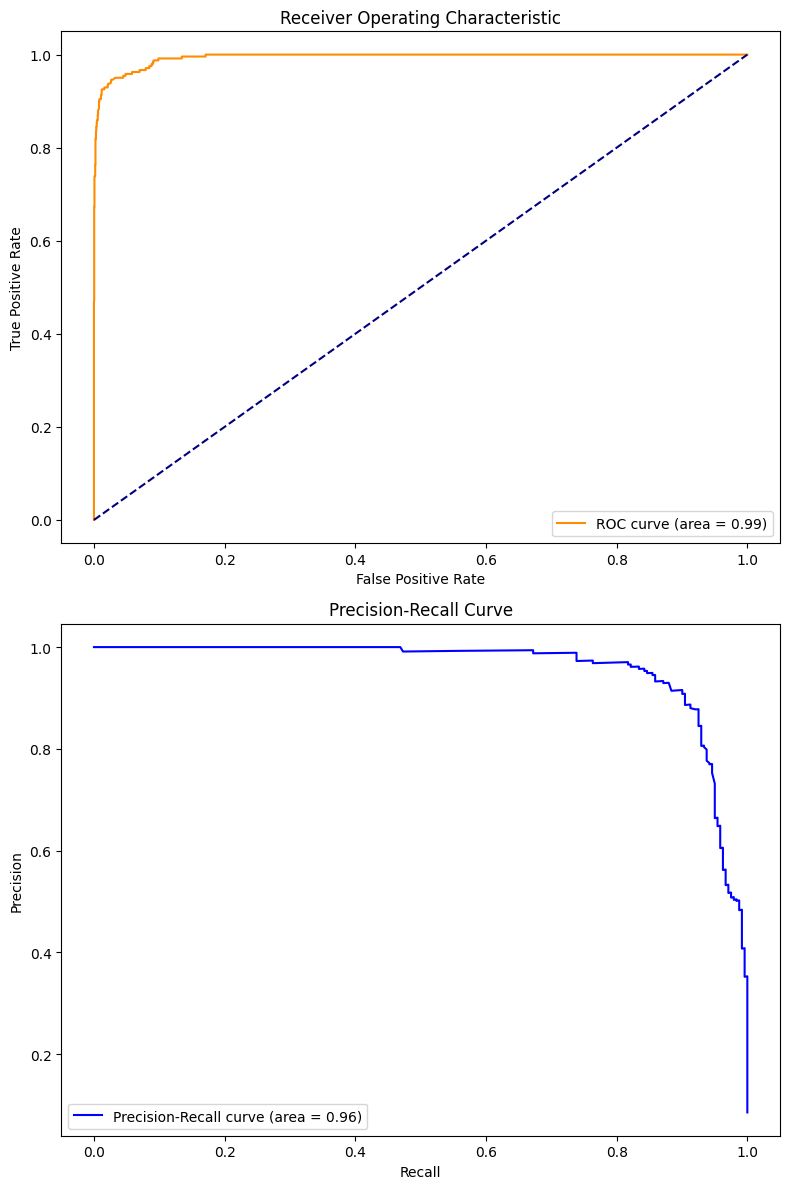

In [17]:
evaluate_model(model, X_test, y_test)